In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_scratch import *
class ConVLayers:
    def __init__(self,layers):
        self.layers=layers

    def forward(self,X):  # Fixed method signature
        cache=[self.layers[0].forward(X)]
        l=0
        for i in range(1,len(self.layers)):
            cache.append(self.layers[i].forward(cache[l][0]))
            l+=1
        return cache

    def backward(self,dZ,Y,cache):  # Fixed method signature
        for l in reversed(range(len(self.layers))):
            dZ = self.layers[l].backward(dZ, cache[l][1])
        return dZ

class Conv2D:
    def __init__(self,input_size,f,n_C,lr,stride=1):
        (m,H_prev,W_prev,n_C_prev)=input_size
        pad=(f-1)//2
        self.lr=lr
        (self.W,self.b)=initialize_conv_parameters(f,n_C_prev,n_C)
        self.params={'stride':stride,'pad':pad}

    def forward(self,A_prev):
        return conv_forward(A_prev,self.W,self.b,self.params)

    def backward(self,dZ,cache):
        dA_prev, dW, db = conv_backward(dZ,cache)
        # Update weights and biases
        self.W -= self.lr*dW
        self.b -= self.lr*db
        return dA_prev

class MaxPool2D:
    def __init__(self,f,stride):
        self.params={'f':f,'stride':stride}
    def forward(self,A_prev):
        return pool_forward(A_prev,self.params)
    def backward(self,dA,cache):
        return pool_backward(dA,cache)

class Dense:
    def __init__(self,layer_dims):
        self.params=initialize_parameters_deep(layer_dims)
    def forward(self,X):
        return L_model_forward(X,self.params)
    def backward(self,AL,Y,caches):
        return L_model_backward(AL,Y,caches)
    def update(self,grads,learning_rate):
        self.params= update_parameters(self.params,grads,learning_rate)
class CNN:
    def __init__(self,conv,dense):
        self.conv=conv
        self.dense=dense
    def forward(self,X):
        c=self.conv.forward(X)
        c1=c[-1][0].reshape(-1,X.shape[0])
        p=self.dense.forward(c1)
        return c,p
    def print_cost(self,p,Y):
        cost=compute_cost(p[0],Y)
        print(cost)
        return cost
    def backward(self,p,Y,c,lr):
        shape=c[-1][0].shape
        dZ=p[0].reshape(-1,p[0].shape[1])
        x=self.dense.backward(dZ,Y,p[1])
        dA=x['dA0']
        self.dense.update(x,lr)
        dA=dA.reshape(shape)
        self.conv.backward(dA,Y,c)
a = [
    Conv2D((5,28,28,1), 3, 128,0.001),     # 28x28 -> 28x28 (pad=1)
    MaxPool2D(2, 2),                  # 28x28 -> 14x14
    Conv2D((5,14,14,128), 3, 64,0.001),    # 14x14 -> 14x14 (pad=1)
    MaxPool2D(2, 2),                  # 14x14 -> 7x7
    Conv2D((5,7,7,64), 3, 32,0.001),       # 7x7 -> 7x7 (pad=1)
    MaxPool2D(2, 2)                   # 7x7 -> 4x4
]
import json
# a = [
#     Conv2D((5,28,28,1), 3, 128,0.001),     # 28x28 -> 28x28 (pad=1)
#     MaxPool2D(2, 2),                  # 28x28 -> 14x14
#     Conv2D((5,14,14,128), 3, 64,0.001),    # 14x14 -> 14x14 (pad=1)
#     MaxPool2D(2, 2),                  # 14x14 -> 7x7
#     Conv2D((5,7,7,64), 3, 32,0.001),       # 7x7 -> 7x7 (pad=1)
#     MaxPool2D(2, 2)                   # 7x7 -> 4x4
# ]
#                          activation shape    activation size     parameters
# input                   (28,28,1)               784                 0
#conv1= (5x5), stride=1   (28, 28, 128)           100352              3328
#pool1= f=2, s=2          (14, 14, 128)           25088               0
#conv2= (3x3), stride=1   (14, 14, 64)            12544               640
#pool2= f=2, s=2          (7, 7, 64)              3136                0
#conv3= (3x3)  stride=1   (7, 7, 32)              1568                320
#pool3= f=2, s=2          (4, 4, 32)              512                 0
#dense1                   (512,1)                 512                 262145
#dense2= (softmax)        (10,1)                  10                  5121

conv=ConVLayers(a)
dens=Dense([512,24])
cnn=CNN(conv,dens)

def load_params_from_json(filename='final_params.json'):
    try:
        with open(filename, 'r') as f:
            params_dict = json.load(f)
        conv_params = [
            (np.array(params_dict['conv1']['W']), np.array(params_dict['conv1']['b'])),
            (np.array(params_dict['conv2']['W']), np.array(params_dict['conv2']['b'])),
            (np.array(params_dict['conv3']['W']), np.array(params_dict['conv3']['b']))
        ]
        dense_params = {k: np.array(v) for k, v in params_dict['dens'].items()}
        return conv_params, dense_params
    except (json.JSONDecodeError, FileNotFoundError):
        return None, None
# Update the model parameters
def save_params_to_json(params, filename='final_params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
conv_params, dense_params = load_params_from_json()
for i, (W, b) in enumerate(conv_params):
    a[i*2].W = W
    a[i*2].b = b

dens.params = dense_params
idx=[i for i in range(10000)]
costs = []

def save_cost_to_file(cost, filename='costs.txt'):
    with open(filename, 'a') as f:
        f.write(f"{cost}\n")

# with open('costs.txt', 'r') as f:
#     start_index = len(f.readlines())

# for i in range(start_index, 100000):
#     params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
#     save_params_to_json(params)
#     np.random.shuffle(idx)
#     y_train2 = y_train1[idx[0]:idx[0]+1].T.values
#     x_train3 = X_train2[idx[0]:idx[0]+1]
#     (c, p) = cnn.forward(x_train3)
#     cost = cnn.print_cost(p, y_train2)
#     cnn.backward(p, y_train2, c, 0.001)
#     costs.append(cost)
#     save_cost_to_file(cost)
import json
def save_params_to_json(params, filename='params.json'):
    params_dict = {
        'conv1': {'W': params[0][0].tolist(), 'b': params[0][1].tolist()},
        'conv2': {'W': params[1][0].tolist(), 'b': params[1][1].tolist()},
        'conv3': {'W': params[2][0].tolist(), 'b': params[2][1].tolist()},
        'dens': {k: v.tolist() for k, v in params[3].items()}
    }
    with open(filename, 'w') as f:
        json.dump(params_dict, f)

params = [(a[0].W, a[0].b), (a[2].W, a[2].b), (a[4].W, a[4].b), dens.params]
save_params_to_json(params)
conv_params, dense_params = load_params_from_json(filename='final_params.json')
if conv_params is not None and dense_params is not None:
    for j, (W, b) in enumerate(conv_params):
        a[j*2].W = W
        a[j*2].b = b
    dens.params = dense_params
def predict(X, parameters):
    """
    Predict class labels for input data.

    Arguments:
    X -- input data of shape (n_features, m_examples)
    parameters -- trained parameters from the L-layer model

    Returns:
    predictions -- vector of predictions of shape (1, m_examples)
    """
    # Forward propagation
    AL, _ = L_model_forward(X, parameters)

    # Get predictions by taking argmax of the output probabilities
    predictions = np.argmax(AL, axis=0)

    return predictions

def compute_accuracy(predictions, Y):
    """
    Calculate accuracy of predictions compared to true labels.

    Arguments:
    predictions -- vector of predictions of shape (1, m_examples)
    Y -- true labels vector of shape (n_classes, m_examples)

    Returns:
    accuracy -- scalar value, accuracy of predictions in percentage
    """
    # Convert one-hot encoded Y to class labels
    true_labels = np.argmax(Y, axis=0)

    # Calculate accuracy
    m = Y.shape[1]
    accuracy = np.sum(predictions == true_labels) / m * 100

    return accuracy

def pred(X,cnn):
    (c, p) =cnn.forward(X)
    prediction=predict(c[-1][0].reshape(1,-1),dens.params)
    return prediction
import cv2 as cv

[ WARN:0@2295.982] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


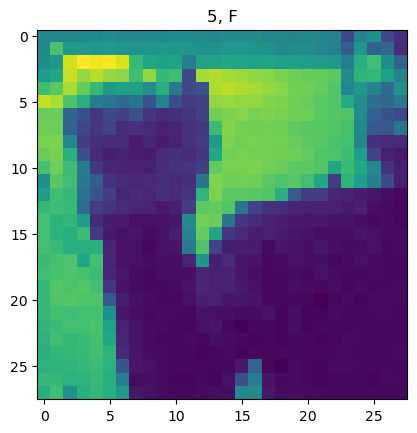

[ WARN:0@2297.748] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


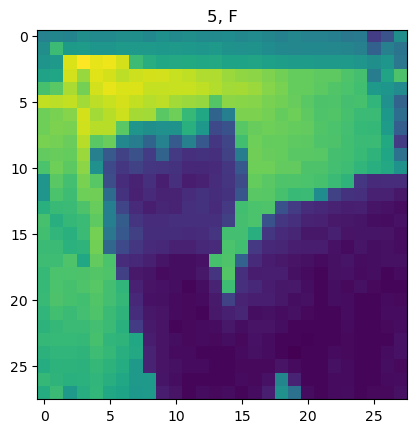

[ WARN:0@2299.546] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


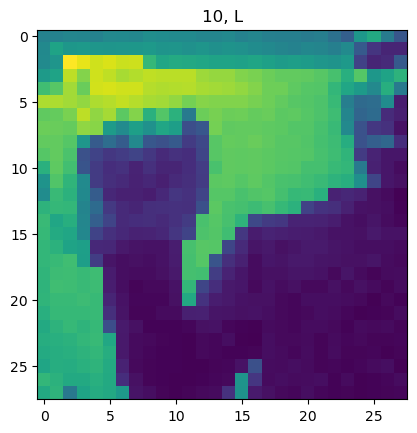

[ WARN:0@2301.930] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


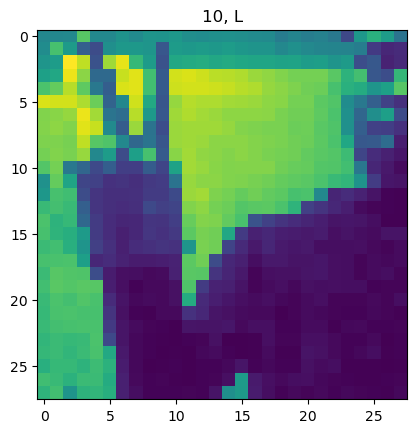

[ WARN:0@2304.272] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


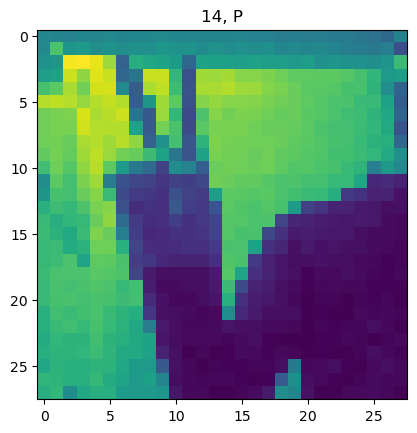

[ WARN:0@2306.241] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


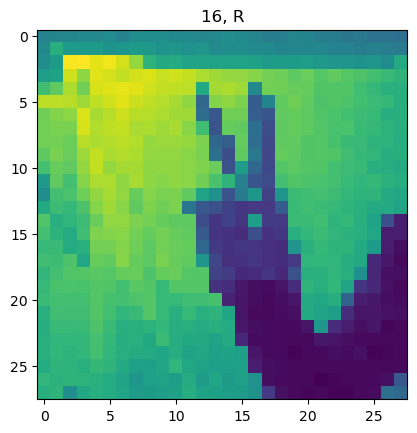

[ WARN:0@2308.493] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


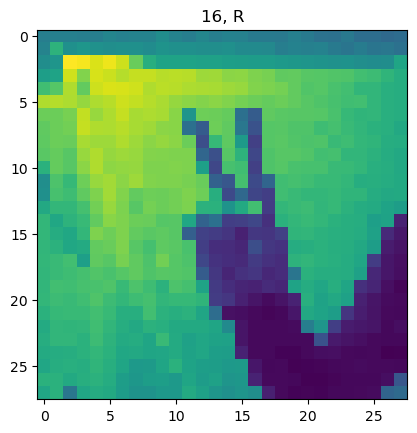

[ WARN:0@2310.991] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


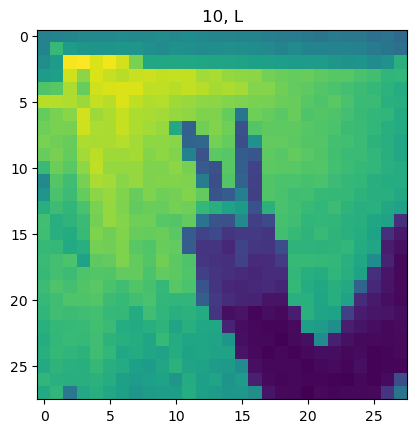

[ WARN:0@2313.339] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


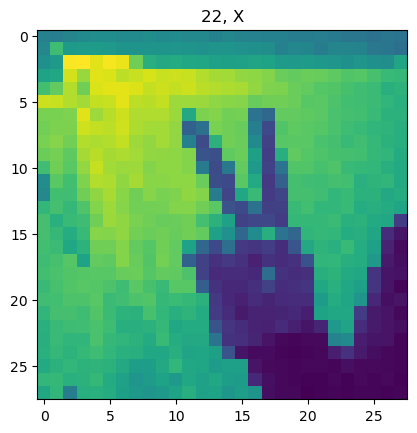

[ WARN:0@2315.738] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


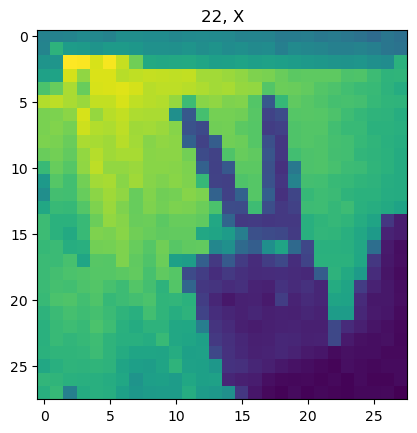

[ WARN:0@2318.048] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


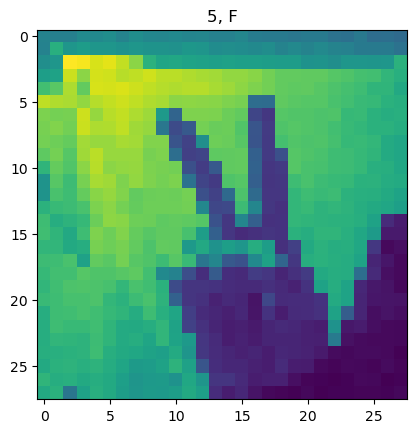

[ WARN:0@2320.109] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


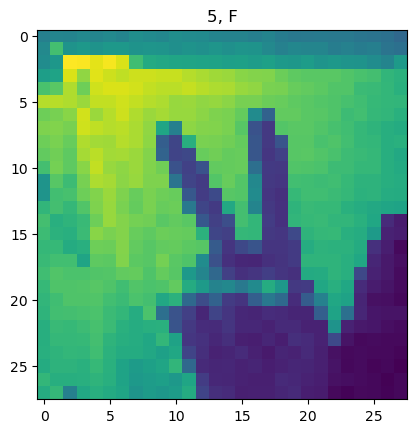

[ WARN:0@2322.251] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


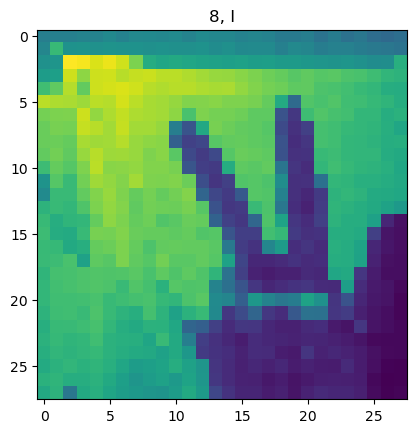

[ WARN:0@2324.855] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


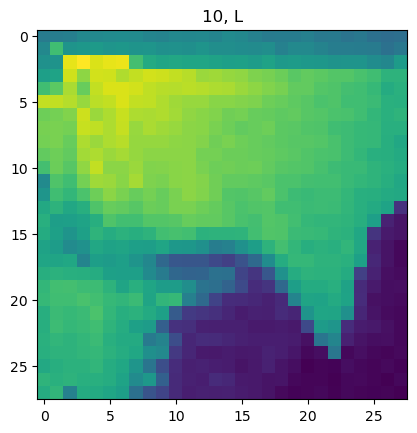

[ WARN:0@2327.097] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


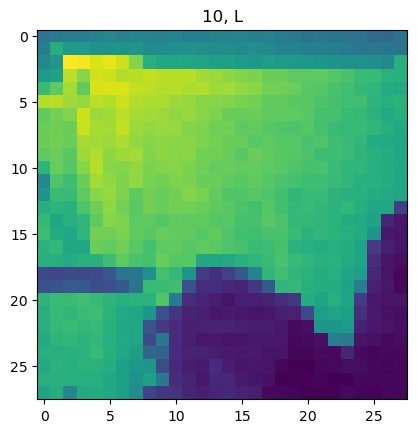

[ WARN:0@2329.305] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


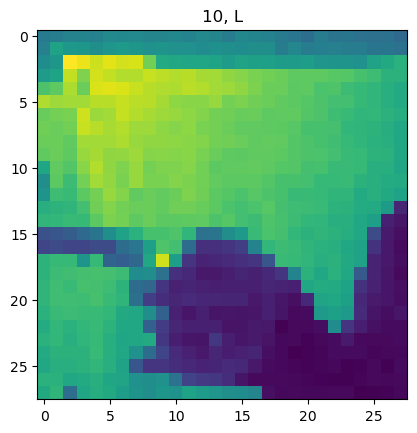

[ WARN:0@2331.360] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


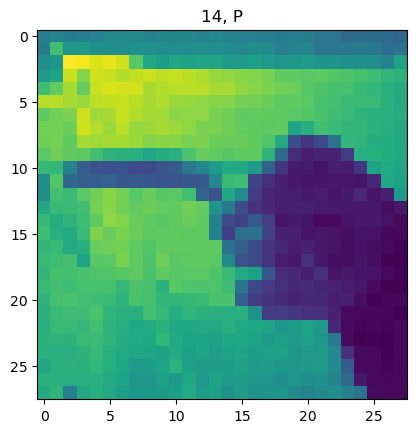

[ WARN:0@2333.775] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


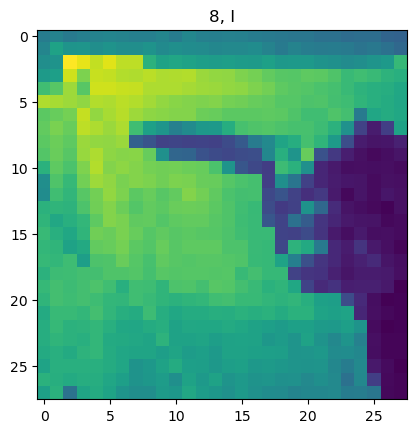

[ WARN:0@2336.124] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


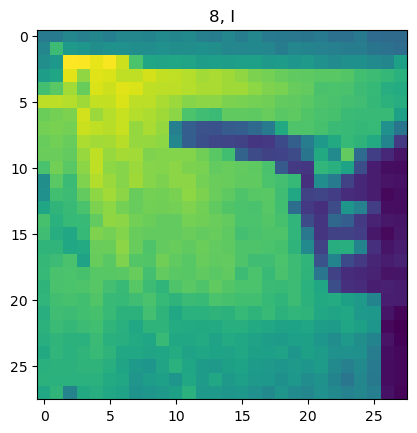

[ WARN:0@2338.589] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


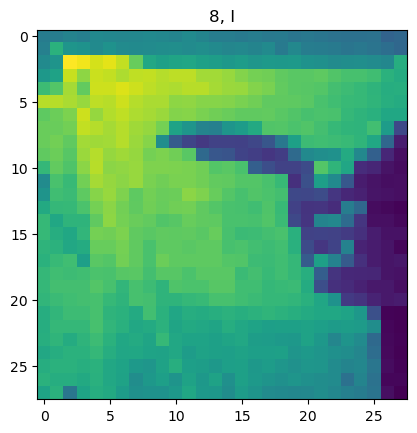

[ WARN:0@2341.103] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


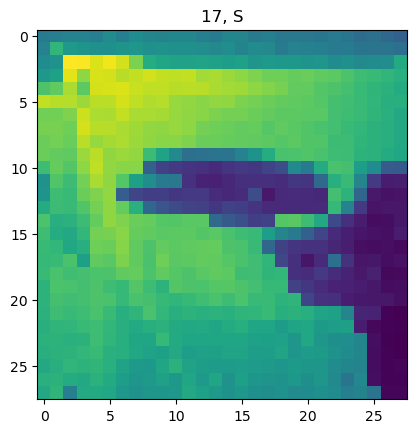

[ WARN:0@2343.674] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


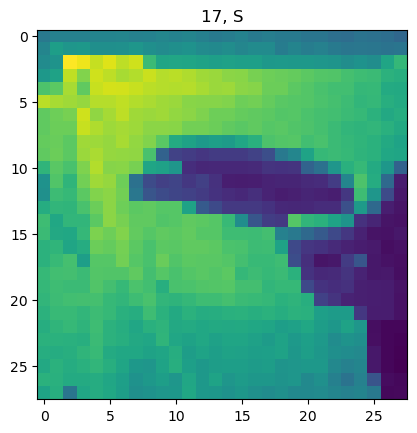

[ WARN:0@2346.151] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


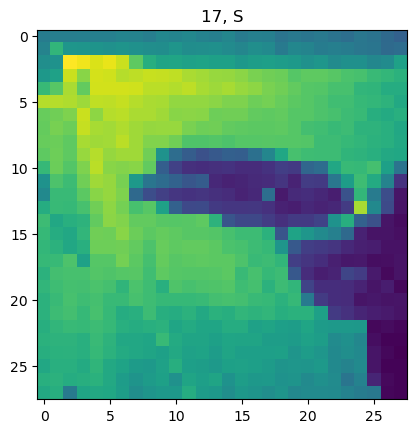

[ WARN:0@2348.338] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


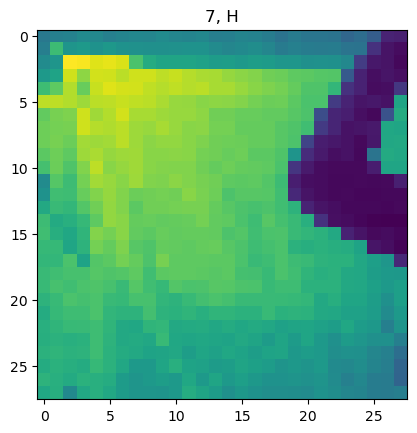

[ WARN:0@2350.443] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


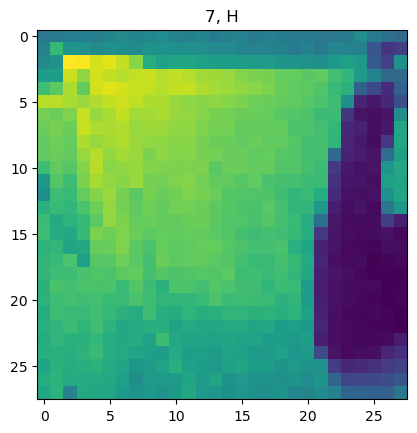

[ WARN:0@2352.694] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


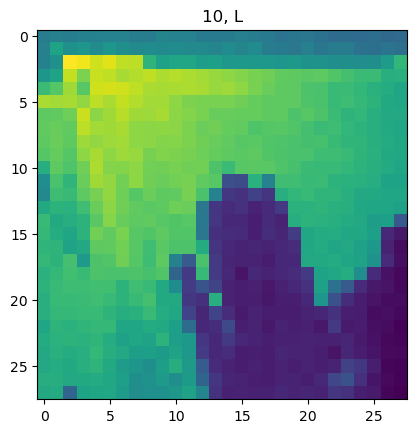

[ WARN:0@2355.005] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


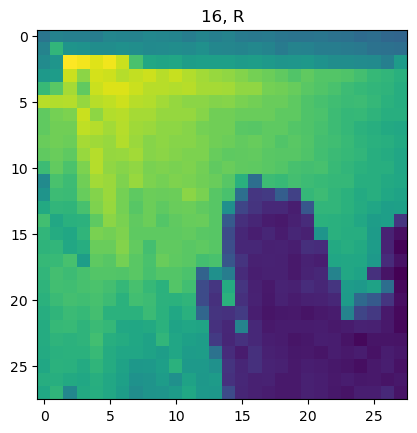

[ WARN:0@2357.095] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


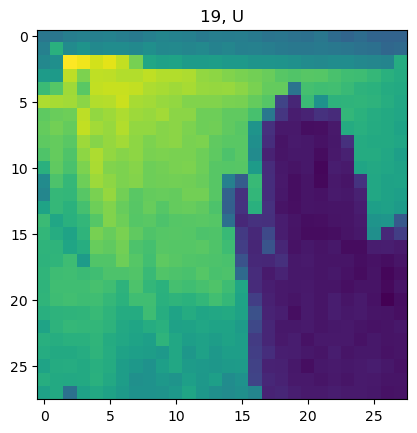

[ WARN:0@2359.543] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


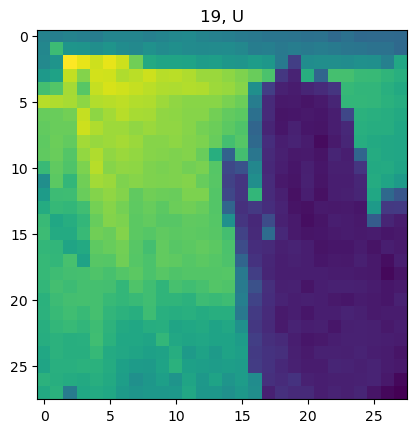

[ WARN:0@2361.774] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


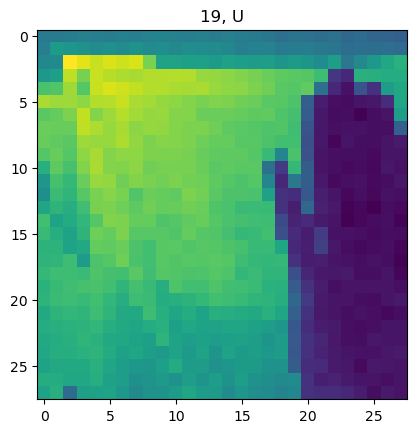

[ WARN:0@2364.192] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


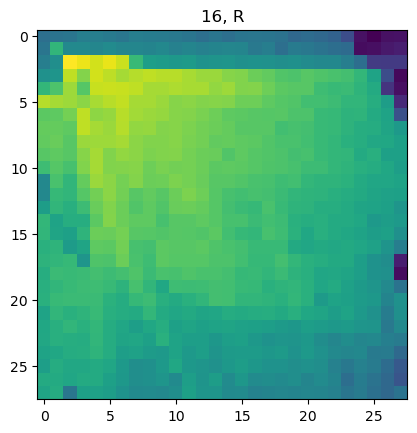

[ WARN:0@2366.195] global ./modules/videoio/src/cap_gstreamer.cpp (1405) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


KeyboardInterrupt: 

In [248]:
for i in range(10000):
    cap = cv.VideoCapture(0)
    _, pic = cap.read()
    # Crop the center square region
    h, w = pic.shape[:2]
    side = min(h, w)
    start_y = (h - side) // 2
    start_x = (w - side) // 2
    pic = pic[start_y:start_y+side, start_x:start_x+side]

    pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
    pic = pic.reshape(pic.shape[0], pic.shape[1], 1)
    pic = cv.resize(pic, (28, 28)).reshape(28, 28, 1)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
    dic={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'K',10:'L',11:'M',12:'N',13:'O',14:'P',15:'Q',16:'R',17:'S',18:'T',19:'U',20:'V',21:'W',22:'X',23:'Y'}
    pre=pred(np.array([pic]),cnn)
    plt.title(f"{pre[0]}, {dic[pre[0]]}")
    plt.imshow(pic)
    plt.show()
    cap.release()